# About

## Fake News Classification - ML Approaches


#### LIAR 2 Dataset

Github link : https://github.com/chengxuphd/liar2

Hugging Face Link : https://huggingface.co/datasets/chengxuphd/liar2

Dataset Info:

1. id (int64)
2. label (int64) - total 6 (pants-fire, false, barelytrue, half-true, mostly-true, and true)
3. statement (string)
4. date (string)
5. subject (string)
6. speaker (string)
7. speaker_description (string)
8. state info (string)

Credit history (9 - 14) - includes the historical counts of inaccurate statements for each speaker including current statement -

9. true counts (int64)
10. barely true counts. (int64)
11. false counts. (int64)
12. half true counts. (int64)
13. mostly true counts. (int64)
14. pants on fire counts. (int64)
15. context (string)
16. justification (string)

Liar Dataset : https://arxiv.org/pdf/1705.00648

Liar2 Dataset : https://ieeexplore.ieee.org/document/10568915?denied=

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which 

In [3]:
from datasets import load_dataset

# load dataset from hugging face
dataset = load_dataset("chengxuphd/liar2")

train_df = dataset["train"].to_pandas()
val_df = dataset["validation"].to_pandas()
test_df = dataset["test"].to_pandas()

README.md:   0%|          | 0.00/2.87k [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/19.0M [00:00<?, ?B/s]

valid.csv:   0%|          | 0.00/2.38M [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/2.38M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/18369 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2297 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2296 [00:00<?, ? examples/s]

# Without Data Imputation

## Data Processing

In [4]:
# Drop nulls values

train_df = train_df.dropna()
val_df = val_df.dropna()
test_df = test_df.dropna()

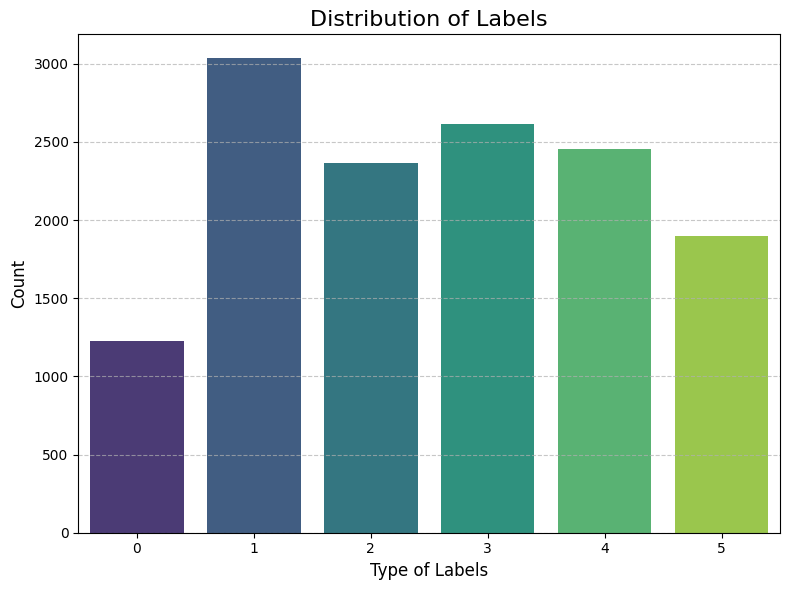

In [5]:
# Visualise target variable (label)

plt.figure(figsize=(8, 6))
sns.countplot(data=train_df, x='label', palette='viridis')
plt.title('Distribution of Labels', fontsize=16)
plt.xlabel('Type of Labels', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [6]:
'''
text and metadata processing

DONE : Tried one with speaker_description and context - MODEL NOT FITTING (max 61% accuracy)
DONE : Try one without 'speaker_descriptions' and 'context' - MODEL NOT FITTING (max 62% accuracy)
DONE : Try one with processing 'subject' and 'speaker' as categorical cols alongside 'state_info' while excluding context and speaker_description - MODEL NOT FITTING (max 62% accuracy)
TODO : Try one with processing 'subject' and 'speaker' as categorical cols alongside 'state_info' while including context and speaker_description


'''

def preprocess(df):
    # text features
    df["text"] = df["statement"] + " " + df["context"] + " " + df["speaker_description"] + " " + df["justification"]

    # frequency encoding for high-cardinality strings
    # df['subject_freq'] = df.groupby('subject')['subject'].transform('count') / len(df)
    # df['speaker_freq'] = df.groupby('speaker')['speaker'].transform('count') / len(df)

    return df

In [7]:
train_df = preprocess(train_df)
val_df = preprocess(val_df)
test_df = preprocess(test_df)

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# numeric features
numeric_cols = [
    'true_counts', 'mostly_true_counts', 'half_true_counts',
    'mostly_false_counts', 'false_counts',	'pants_on_fire_counts'
]

# categorical features
categorical_cols = [
    'subject', 'speaker', 'state_info'
]

# fit TF-IDF ONLY on train to prevent data leakage
tfidf = TfidfVectorizer(max_features=10000, stop_words='english')
X_train_text = tfidf.fit_transform(train_df["text"])

# transform all splits
X_val_text = tfidf.transform(val_df["text"])
X_test_text = tfidf.transform(test_df["text"])

# numeric scaling (fit on train)
scaler = MinMaxScaler()
X_train_num = scaler.fit_transform(train_df[numeric_cols])

X_val_num = scaler.transform(val_df[numeric_cols])
X_test_num = scaler.transform(test_df[numeric_cols])



# One-hot encoding (fit on train)
ohe = OneHotEncoder(handle_unknown='ignore')
# X_train_cat = ohe.fit_transform(train_df[['state_info']])

# X_val_cat = ohe.transform(val_df[['state_info']])
# X_test_cat = ohe.transform(test_df[['state_info']])

X_train_cat = ohe.fit_transform(train_df[categorical_cols])

X_val_cat = ohe.transform(val_df[categorical_cols])
X_test_cat = ohe.transform(test_df[categorical_cols])

In [9]:
import scipy.sparse

# combining features for each split

# def combine_features(text, num, cat, df):
#     return scipy.sparse.hstack([
#         text, num, cat, df[['subject_freq', 'speaker_freq']].values
#     ])

def combine_features(text, num, cat, df):
    return scipy.sparse.hstack([
        text, num, cat
    ])

In [10]:
X_train = combine_features(X_train_text, X_train_num, X_train_cat, train_df)
X_val = combine_features(X_val_text, X_val_num, X_val_cat, val_df)
X_test = combine_features(X_test_text, X_test_num, X_test_cat, test_df)

In [11]:
# label separation

y_train = train_df['label'].values
y_val = val_df['label'].values
y_test = test_df['label'].values

## Model Training

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

In [21]:
# Parameter tuning using GridSearchCV

param_grids = {
    'Logistic_Regression': {
        'model': LogisticRegression(),
        'params': {
            'C': [0.01, 0.1, 1],
            'solver': ['newton-cg', 'sag','lbfgs'],
            'max_iter': [100, 200, 500],
            'class_weight': [None, 'balanced'],
        }
    },
    'Random_Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [5, 10, 20],
            'min_samples_split': [2, 5, 10],
            'class_weight': [None, 'balanced', 'balanced_subsample'],
        }
    },
    'XGBoost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
        'params': {
            'n_estimators': [100, 200, 500],
            'learning_rate': [0.001, 0.01, 0.1, 0.3],
            'max_depth': [3, 6, 10],
            'min_child_weight': [1, 3, 5],
            'gamma': [0, 0.1, 0.2],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'reg_alpha': [0, 0.1, 1],
            'reg_lambda': [0, 0.1, 1],
        }
    }
}

In [ ]:
from sklearn.model_selection import GridSearchCV

best_models = {}
model_accuracies = {}

for model_name, model_info in param_grids.items():
    print(f"-- Tuning hyperparameters for {model_name}...\n")
    grid_search = GridSearchCV(
        estimator=model_info['model'],
        param_grid=model_info['params'],
        scoring='f1_macro',
        cv=10,   # 10-fold cross-validation
        n_jobs=-1
    )

    # train the model
    grid_search.fit(X_train, y_train)

    # save the best model parameters
    best_models[model_name] = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"\nF1 score (macro): {grid_search.best_score_}")

    # Get training accuracy
    y_pred_train = grid_search.best_estimator_.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_pred_train)
    print(f"\n\nTrain Accuracy: {train_accuracy}")

    # Evaluate the model on the validation set
    y_pred_val = grid_search.best_estimator_.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_pred_val)

    # Save Validation accuracy
    model_accuracies[model_name] = val_accuracy
    print(f"Validation Accuracy: {val_accuracy}")

    # print classification report
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred_val, digits=3))

-- Tuning hyperparameters for Logistic_Regression...

Best parameters for Logistic_Regression: {'C': 1, 'class_weight': 'balanced', 'max_iter': 500, 'solver': 'sag'}

F1 score (macro): 0.4365959973532897


Train Accuracy: 0.8686185081653671
Validation Accuracy: 0.4365781710914454

Classification Report:
              precision    recall  f1-score   support

           0      0.345     0.382     0.362       152
           1      0.416     0.391     0.403       386
           2      0.523     0.416     0.463       296
           3      0.508     0.511     0.510       311
           4      0.431     0.421     0.426       311
           5      0.378     0.494     0.428       239

    accuracy                          0.437      1695
   macro avg      0.434     0.436     0.432      1695
weighted avg      0.443     0.437     0.437      1695

-- Tuning hyperparameters for Random_Forest...

Best parameters for Random_Forest: {'class_weight': 'balanced_subsample', 'max_depth': 20, 'min_samples_

In [17]:
# models to evaluate

models = {
    "Logistic Regression": LogisticRegression(C=1, class_weight='balanced', max_iter=100, solver='newton-cg'),
    "Random Forest" : RandomForestClassifier(class_weight='balanced_subsample', max_depth=20, min_samples_split=5, n_estimators=200),
    # "XGBoost" : XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

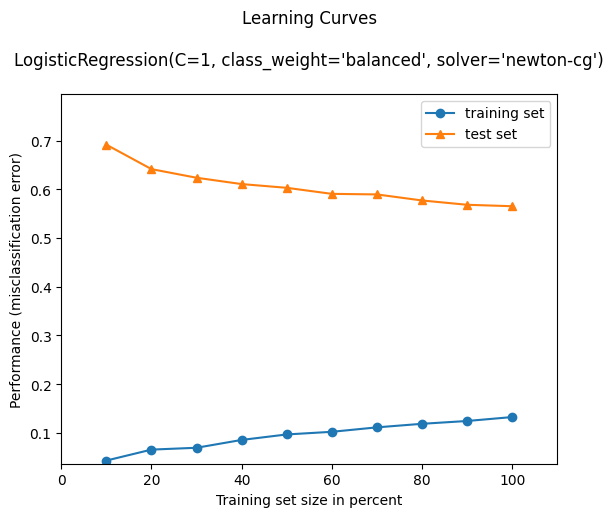

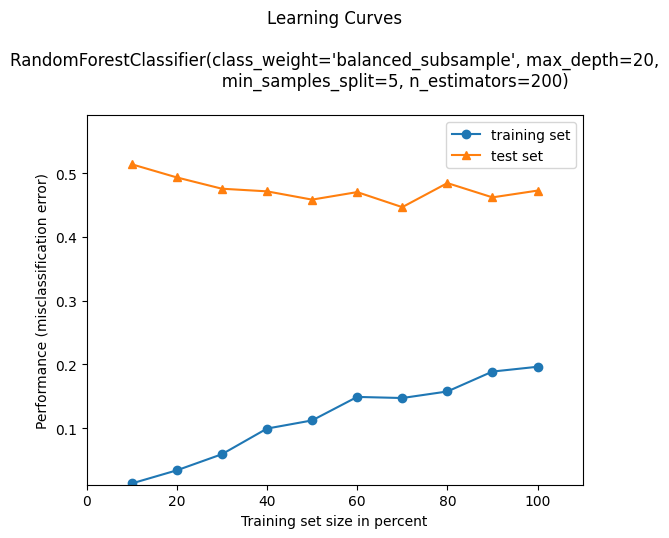

In [14]:
# plotting learning curve for each model

from mlxtend.plotting import plot_learning_curves

for name, model in models.items():
    plot_learning_curves(X_train.toarray(), y_train, X_val.toarray(), y_val, model)
    plt.show()

In [19]:
# model evaluation

from sklearn.model_selection import cross_val_score

results = {}

for name, model in models.items():
    print(f"\n=== {name} Evaluation ===")

    # cross validation accuracy
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    print(f"\n10 Fold CV Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

    # train and evaluate on test set
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # classification_report
    print("\nTest Set Classification Report:")
    print(classification_report(y_test, y_pred, digits=3))

    # store results
    results[name] = {
        'cv_mean_accuracy': cv_scores.mean(),
        'cv_std_accuracy': cv_scores.std(),
        'classification_report': classification_report(y_test, y_pred, output_dict=True)
    }



=== Logistic Regression Evaluation ===

10 Fold CV Accuracy: 0.4358 (±0.0092)

Test Set Classification Report:
              precision    recall  f1-score   support

           0      0.368     0.427     0.395       157
           1      0.425     0.393     0.408       354
           2      0.520     0.472     0.495       303
           3      0.491     0.432     0.460       324
           4      0.443     0.453     0.448       307
           5      0.361     0.456     0.403       237

    accuracy                          0.438      1682
   macro avg      0.435     0.439     0.435      1682
weighted avg      0.444     0.438     0.439      1682


=== Random Forest Evaluation ===

10 Fold CV Accuracy: 0.5413 (±0.0133)

Test Set Classification Report:
              precision    recall  f1-score   support

           0      0.582     0.631     0.606       157
           1      0.596     0.463     0.521       354
           2      0.734     0.492     0.589       303
           3      0.59

# With Data imputation

In [ ]:
train_df.isnull().sum()